### Constant Product formula theory: **x * y >= k**
The constant product formula dictates that in a pair pool of token X and token Y, the product of the two asset quantities in the pool (X times Y) at all times should remain constant at the very least.


In [70]:
x = 100.0 # ETH
y = 100.0 # USDC
k = x * y

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [238]:
def plot_constant_product(
        X: float, Y: float, K: float,
        X_label: str = "ETH",
        Y_label: str = "USDC",
        axis_limit: int = 200,
        plot_size: int = 7
) -> None:
    
    # obtain (x, y) point to plot a line
    xplot = torch.linspace(0.1, axis_limit, axis_limit)
    yplot = K / xplot
    
    plt.figure(figsize=(plot_size, plot_size))  # set plot size
    
    # fill area, where the constant product formula is preserved
    plt.fill_between(xplot, yplot, axis_limit, color="purple", alpha=0.4, label=f"x * y >= k (pre-swap)")
    # fill area of the constant product
    plt.fill_between([0, X], 0, Y, color="teal", alpha=0.4, label=f"k (post-swap)")
    
    plt.text(axis_limit * 3/4, axis_limit * 3/4, f"x * y >= k\n({K:.2f})", color="purple", fontsize=20, ha="center", va="center")
    plt.text(X / 2, Y / 2, f"k\n({X * Y:.2f})", color="teal", fontsize=20, ha="center", va="center")

    # set axis limits and labels, display legend
    plt.xlim(0, axis_limit)
    plt.ylim(0, axis_limit)
    plt.xlabel(f"x ({X_label})")
    plt.ylabel(f"y ({Y_label})")
    plt.legend()

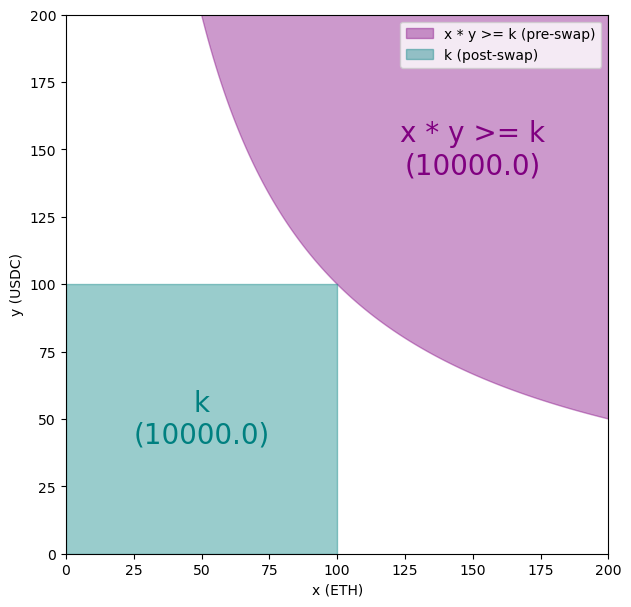

In [143]:
plot_constant_product(x, y, k)

In practice, the constant product formula is implemented through comparing the constant product of the liquidity pool before and after the trade to ensure it remains at least constant.
<div align="center">

k_Before < k_After <br>
x_Before * y_Before < x_After * y_After

</div>
To determine if a swap is valid or not, we need to pre-calculate how the swap would affect the constant product of the pool. Does it remain at least the same?

We’ll denote ΔETH & ΔUSDC as the amount swapped into and out of the liquidity pool respectively.
<div align="center">

100 ETH x 100 USDC <= (100 ETH + ΔETH) * (100 USDC + ΔUSDC)

</div>

In [144]:
x * y <= (x + 25) * (x - 25)
print(f"before: {x * y}")
print(f"after:   {(x + 25) * (x - 25)}")

before: 10000.0
after:   9375.0


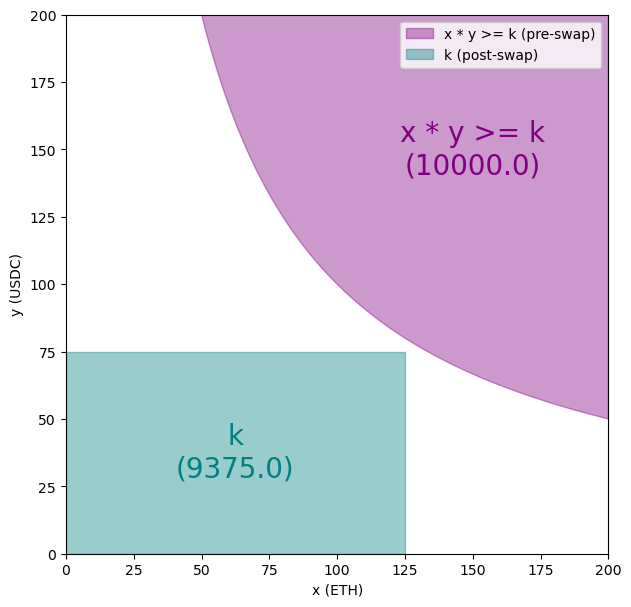

In [145]:
plot_constant_product(x + 25, y - 25, k)

Clearly, we cannot expect to withdraw 25 USDC — we will have to withdraw less to preserve the constant product invariant.
<div align="center">

100 ETH x 100 USDC <= (100 ETH + 25 ETH) x (100 USDC - ΔUSDC) <br>
100 ETH x 100 USDC <= 125 ETH x (100 USDC - ΔUSDC) <br>
100 ETH x 100 USDC / 125 ETH <= (100 USDC - ΔUSDC) <br>
(100 ETH x 100 USDC / 125 ETH) - 100 USDC <= -ΔUSDC <br>
ΔUSDC <= 100 USDC - (100 ETH x 100 USDC / 125 ETH) <br> <br>
ΔUSDC <= 100 USDC - 80 USDC <br>
ΔUSDC <= 20 USDC

</div>
The pool now has 125 ETH and 80 USDC, which amounts to a constant product of 10,000

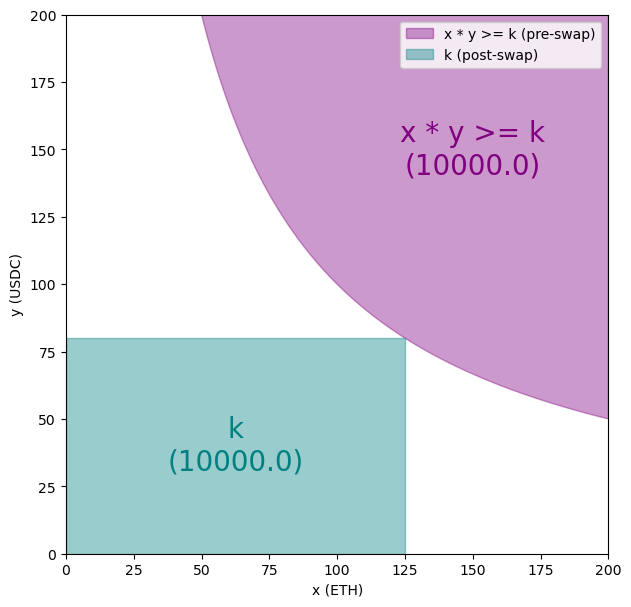

In [146]:
plot_constant_product(x + 25, y - 20, k)

Swapping 25 ETH for 20 USDC is the most amount of USDC you can extract from the AMM liquidity pool. This swap is accepted since it preserves the constant product formula. 20 USDC is one-fifth less than 25 USDC, hence we experienced slippage during this swap. Slippage is the degree to which the price moves as a result of our trade. If we placed a smaller trade, the price we end up paying would be close to 1 USDC : 1 ETH. But because our trade is large, we end up paying a higher price for less USDC, thus incurring a higher slippage

Generalized formula for calculating the swap can be expressed as follows: <br>

<div align="center">

Δy <= y - ( (x * y) / (x + Δx) ), where: <br>
1) x and y represents the quantity of tokens in the liquidity pool before the swap <br>
2) Δx represents the amount of token deposited into the AMM <br>
3) Δy represents the amount swapped out of the AMM <br>

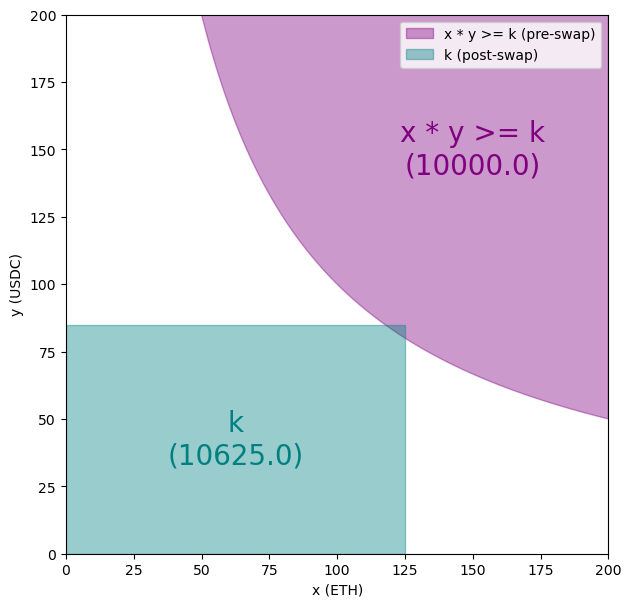

In [151]:
plot_constant_product(x + 25, y - 15, k)

If you take out less, for example 15 USDC, the AMM would still accept it since the constant product in the liquidity pool increases, but you are at a loss since you did not maximize your swap. <br> <br>
The calculations we performed above were “theoretical” which excluded trading fees. As mentioned before, Uniswap V2 applies a 0.3% trading fee for every swap, but the fees only apply towards the token deposited into the AMM. Say we swapped token X for token Y, 0.3% fee is taken out only from X, and not from Y.

In [159]:
delta_x = 25.0

uniswap_fee = delta_x * 0.003  # 0.3%
delta_x_after_fee = delta_x * 0.997  # 97.3%

delta_y = y - ((x * y) / (x + delta_x_after_fee))
print(f"Withdrawn USDC amount: {delta_y}")

Withdrawn USDC amount: 19.951971182709627


Accounting for the 0.3% swapping fee, we could withdraw approximately 19.952 USDC from the AMM. This is less than the 20 USDC we could receive in the example with no fees.

The primary difference in calculation when factoring in fees is that we multiply the deposited token by 99.7%, 0.3% is set aside and allocated to the AMM. Given Δx is the deposited token and Δy is the withdrawn token amount, the general equation becomes:
<div align="center">
Δy <= y - ( (x * y) / (x + (Δx * 0.997)) )

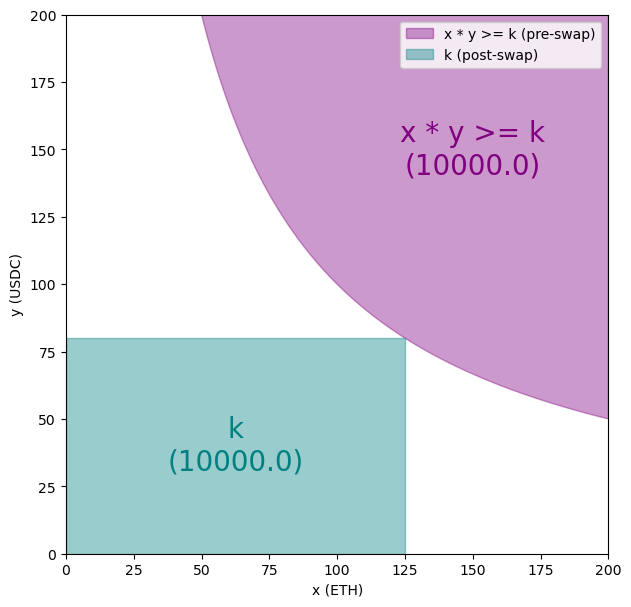

In [160]:
plot_constant_product(x + delta_x_after_fee, y - delta_y, k)

For now: <br>
1) Find a way to get token data for each swap. - **Done!**
2) Test what I've build on real world data.
3) Project my task on what I've learned.
4) Detect parameters, that I'm playing with.
5) Apply ML if possible.

In [288]:
def swap_y_for_x(X: float, Y: float, delta_X: float):
    delta_X_after_fee = delta_X * 0.997  # uniswap fee
    # delta_Y = Y - ((X * Y) / (X + delta_X_after_fee))  # straightforward
    delta_Y = (Y * delta_X_after_fee) / (X + delta_X_after_fee)  # rearranged
    return delta_Y


def handler(trades_data: dict, pool_data: dict) -> None:
    # general data about swap
    purchase_kind = trades_data["data"][0]["attributes"]["kind"]
    purchase_in_usd = float(trades_data["data"][0]["attributes"]["volume_in_usd"])
    
    # actual deltas of swapped tokens
    if purchase_kind == "buy":
        delta_ether = float(trades_data["data"][0]["attributes"]["from_token_amount"])  # x
        delta_coin = float(trades_data["data"][0]["attributes"]["to_token_amount"])  # y
    elif purchase_kind == "sell":
        delta_coin = float(trades_data["data"][0]["attributes"]["from_token_amount"])  # x
        delta_ether = float(trades_data["data"][0]["attributes"]["to_token_amount"])  # y

    # constant parsing
    ether_price_in_usd = float(pool_data["data"]["attributes"]["quote_token_price_usd"])
    coin_price_in_usd = float(pool_data["data"]["attributes"]["base_token_price_usd"])
    pool_liquidity = float(pool_data["data"]["attributes"]["reserve_in_usd"])

    # tokens in pull before swap
    ether_in_pool = pool_liquidity / (2 * ether_price_in_usd)
    coin_in_pool = pool_liquidity / (2 * coin_price_in_usd) 

    print(purchase_kind)
    if purchase_kind == "buy":
        res = swap_y_for_x(
            X=ether_in_pool,
            Y=coin_in_pool,
            delta_X=delta_ether
        )
        print(abs(res - delta_coin) * coin_price_in_usd, "$")

    elif purchase_kind == "sell":
        res = swap_y_for_x(
            X=coin_in_pool,
            Y=ether_in_pool,
            delta_X=delta_coin
        )
        print(abs(res - delta_ether) * ether_price_in_usd, "$")
handler(data, pool_data)

buy
3.983896308183287 $


In [5]:
import json

with open("data/maga_data.json") as f:
    data = json.load(f)

purchase_kind = data["data"][0]["attributes"]["kind"]
purchase_in_usd = float(data["data"][0]["attributes"]["volume_in_usd"])
ether_pushed = float(data["data"][0]["attributes"]["from_token_amount"])
maga_pulled = float(data["data"][0]["attributes"]["to_token_amount"])

print("kind:", purchase_kind)
print(purchase_in_usd, "$")
print(ether_pushed, "ether")
print(maga_pulled, "maga")

kind: buy
2192.06804332256 $
0.82520326256954 ether
17719483.0343486 maga


In [6]:
# constant behaviour
with open("data/maga_pool_data.json") as f:
    pool_data = json.load(f)

ether_price_in_usd = float(pool_data["data"]["attributes"]["quote_token_price_usd"])
maga_price_in_usd = float(pool_data["data"]["attributes"]["base_token_price_usd"])
pool_liquidity = float(pool_data["data"]["attributes"]["reserve_in_usd"])

print("ether ($):", ether_price_in_usd)
print("maga ($):", maga_price_in_usd)
print("liquidity ($):", pool_liquidity)

ether ($): 2656.39769345657
maga ($): 0.000122927697637844
liquidity ($): 2896827.9615


In [7]:
# constant behaviour
ether_in_pool = pool_liquidity / (2 * ether_price_in_usd)
maga_in_pool = pool_liquidity / (2 * maga_price_in_usd)

print("ether in pool:", ether_in_pool)
print("maga in pool:", maga_in_pool)

ether in pool: 545.2549459434624
maga in pool: 11782649545.891254


In [8]:
def swap_y_for_x(X: float, Y: float, delta_X: float):
    delta_X_after_fee = delta_X * 0.997  # uniswap fee
    # delta_Y = Y - ((X * Y) / (X + delta_X_after_fee))  # straightforward
    delta_Y = (Y * delta_X_after_fee) / (X + delta_X_after_fee)  # rearranged
    return delta_Y

res = swap_y_for_x(
    X=ether_in_pool,
    Y=maga_in_pool,
    delta_X=ether_pushed
)
print(res, "maga")

17751891.48569632 maga


In [9]:
error = abs(res - maga_pulled) * maga_price_in_usd
print(error, "$")

3.983896308183287 $


In [10]:
ether = ether_in_pool + ether_pushed
maga = maga_in_pool - res

In [11]:
print(ether, maga)

546.0801492060319 11764897654.405558


In [12]:
flag = ether_in_pool * maga_in_pool <= ether * maga
ratio = (ether * maga) / (ether_in_pool * maga_in_pool)
print(flag, f"---> K ratio: {ratio:.6f}")

True ---> K ratio: 1.000005


In [13]:
new_maga_price = (ether / maga) * ether_price_in_usd
print("old  :", maga_price_in_usd)
print("new  :", new_maga_price)
price_diff = new_maga_price - maga_price_in_usd
print(f"diff : {price_diff:.20f}")
price_ratio = new_maga_price / maga_price_in_usd
print(f"ratio: {(price_ratio - 1.0) * 100:.2f}%")

old  : 0.000122927697637844
new  : 0.00012329950428851538
diff : 0.00000037180665067138
ratio: 0.30%


In [14]:
price_ratio

1.0030245962286446

In [ ]:
target_ratio = 1.003  # 5 %
loss = target_ratio - price_ratio
print(loss)
# if all above was in torch I would just have called loss.backward() and ran ooptimization loop
# loss.backward()

0.04697540377135545


In [387]:
# 1) read pool data, get all the values
# 2) build loss computational graph
# 3) run optimization on input token amount parameter
# 4) return it

In [3]:
a = 2942222222095
res = (2134 / a) * a
print(res)

2134.0


In [4]:
import torch
loss = torch.tensor(float("inf"), dtype=torch.float64)
print(loss)

tensor(inf, dtype=torch.float64)
